# COVID-19 Case Race
> A race chart to see rising cases around the world

- author: Hargun Oberoi
- image: images/covid-overview.png
- hide: false
- badges: false

In [1]:
#hide
import numpy as np
import pandas as pd
from jinja2 import Template
from IPython.display import HTML

In [2]:
#hide

# FETCH
base_url = 'https://raw.githubusercontent.com/pratapvardhan/notebooks/master/covid19/'
paths = {
    'mapping': base_url + 'mapping_countries.csv',
    'overview': base_url + 'overview.tpl'
}

In [3]:
#hide
paths['mapping']

'https://raw.githubusercontent.com/pratapvardhan/notebooks/master/covid19/mapping_countries.csv'

In [4]:
#hide
def get_mappings(url):
    df = pd.read_csv(url)
    return {
        'df': df,
        'replace.country': dict(df.dropna(subset=['Name']).set_index('Country')['Name']),
        'map.continent': dict(df.set_index('Name')['Continent'])
    }

In [5]:
#hide
mapping = get_mappings(paths['mapping'])

In [6]:
#hide
def get_template(path):
    from urllib.parse import urlparse
    if bool(urlparse(path).netloc):
        from urllib.request import urlopen
        return urlopen(path).read().decode('utf8')
    return open(path).read()

In [7]:
#hide
def get_frame(name):
    url = (
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
        f'csse_covid_19_time_series/time_series_covid19_{name}_global.csv')
    df = pd.read_csv(url)
    # rename countries
    df['Country/Region'] = df['Country/Region'].replace(mapping['replace.country'])
    return df

In [8]:
#hide
def get_dates(df):
    dt_cols = df.columns[~df.columns.isin(['Province/State', 'Country/Region', 'Lat', 'Long'])]
    LAST_DATE_I = -1
    # sometimes last column may be empty, then go backwards
    for i in range(-1, -len(dt_cols), -1):
        if not df[dt_cols[i]].fillna(0).eq(0).all():
            LAST_DATE_I = i
            break
    return LAST_DATE_I, dt_cols

In [9]:
#hide
COL_REGION = 'Country/Region'
# Confirmed, Recovered, Deaths
df = get_frame('confirmed')
# dft_: timeseries, dfc_: today country agg
dft_cases = df
dft_deaths = get_frame('deaths')
dft_recovered = get_frame('recovered')
LAST_DATE_I, dt_cols = get_dates(df)

In [10]:
#hide
LAST_DATE_I, dt_cols = get_dates(df)
dt_today =dt_cols[LAST_DATE_I]
# dt_5day = dt_cols[LAST_DATE_I - 5]
dt_yday = dt_cols[LAST_DATE_I - 1]

In [11]:
#hide
dfc_cases = dft_cases.groupby(COL_REGION)[dt_today].sum()
dfc_deaths = dft_deaths.groupby(COL_REGION)[dt_today].sum()
# dfp_cases = dft_cases.groupby(COL_REGION)[dt_5day].sum()
# dfp_deaths = dft_deaths.groupby(COL_REGION)[dt_5day].sum()
dfp_cases = dft_cases.groupby(COL_REGION)[dt_yday].sum()
dfp_deaths = dft_deaths.groupby(COL_REGION)[dt_yday].sum()

In [12]:
#hide
df_table = (pd.DataFrame(dict(Cases = dfc_cases, Deaths = dfc_deaths, PCases = dfp_cases, PDeaths = dfp_deaths))
            .sort_values(by = ['Cases','Deaths'], ascending = [False, False])
            .reset_index())

In [13]:
#hide
for c in 'Cases, Deaths'.split(', '):
    df_table[f'{c} (+)'] = (df_table[c] - df_table[f'P{c}']).clip(0)
    #Clip ça veut dire, les chiffres negatif sont interdit
df_table['Fatality Rate'] = (100* df_table['Deaths']/ df_table['Cases']).round(2)
df_table['Continent'] = df_table['Country/Region'].map(mapping['map.continent'])
df_table.head(5)

Country/Region    Cases  Deaths   PCases  PDeaths  Cases (+)  Deaths (+)  \
0              US  2137731  116963  2114026   116127      23705         836   
1          Brazil   923189   45241   888271    43959      34918        1282   
2          Russia   544725    7274   536484     7081       8241         193   
3           India   354065   11903   343091     9900      10974        2003   
4  United Kingdom   299600   42054   298315    41821       1285         233   

   Fatality Rate      Continent  
0           5.47  North America  
1           4.90  South America  
2           1.34         Europe  
3           3.36           Asia  
4          14.04         Europe

In [14]:
#hide
#delete problematic countries from table
df_table = df_table[~df_table['Country/Region'].isin(['Cape Verde', 'Cruise Ship', 'Kosovo'])]

In [15]:
#hide
df_table = (pd.DataFrame(dict(Cases=dfc_cases, Deaths=dfc_deaths, PCases=dfp_cases, PDeaths=dfp_deaths))
             .sort_values(by=['Cases', 'Deaths'], ascending=[False, False])
             .reset_index())
df_table.rename(columns={'index': 'Country/Region'}, inplace=True)
for c in 'Cases, Deaths'.split(', '):
    df_table[f'{c} (+)'] = (df_table[c] - df_table[f'P{c}']).clip(0)  # DATA BUG
df_table['Fatality Rate'] = (100 * df_table['Deaths'] / df_table['Cases']).round(1)
df_table['Continent'] = df_table['Country/Region'].map(mapping['map.continent'])
df_table.head(5)

Country/Region    Cases  Deaths   PCases  PDeaths  Cases (+)  Deaths (+)  \
0              US  2137731  116963  2114026   116127      23705         836   
1          Brazil   923189   45241   888271    43959      34918        1282   
2          Russia   544725    7274   536484     7081       8241         193   
3           India   354065   11903   343091     9900      10974        2003   
4  United Kingdom   299600   42054   298315    41821       1285         233   

   Fatality Rate      Continent  
0            5.5  North America  
1            4.9  South America  
2            1.3         Europe  
3            3.4           Asia  
4           14.0         Europe

In [16]:
#hide
#delete problematic countries from table
df_table = df_table[~df_table['Country/Region'].isin(['Cape Verde', 'Cruise Ship', 'Kosovo'])]

In [17]:
#hide
metrics = [df_table.columns[index] for index in [1,2,5,6]]
# s_china = df_table[df_table['Country/Region'].eq('China')][metrics].sum().add_prefix('China ')
s_us = df_table[df_table['Country/Region'].eq('US')][metrics].sum().add_prefix('US ')
s_eu = df_table[df_table['Continent'].eq('Europe')][metrics].sum().add_prefix('EU ')
s_ind = df_table[df_table['Country/Region'].eq('India')][metrics].sum().add_prefix('India ')
summary = {'updated': pd.to_datetime(dt_today), 'since': pd.to_datetime(dt_yday)}
summary = {'updated': pd.to_datetime(dt_today), 'since': pd.to_datetime(dt_yday)}
summary = {**summary, **df_table[metrics].sum(), **s_ind, **s_us, **s_eu}

In [18]:
#hide
dft_ct_new_cases = dft_cases.groupby(COL_REGION)[dt_cols].sum().diff(axis=1).fillna(0).astype(int)

In [19]:
#hide
everydaycases = dft_ct_new_cases.cumsum(axis=1)

In [20]:
#hide
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

In [21]:
#hide
t = everydaycases.stack()

In [22]:
#hide
g = t.reset_index(['Country/Region'])

In [23]:
#hide
g.index.name = 'date'

In [24]:
#hide
g = g.reset_index(['date'])

In [25]:
#hide
g.head()

date Country/Region  0
0  1/22/20    Afghanistan  0
1  1/23/20    Afghanistan  0
2  1/24/20    Afghanistan  0
3  1/25/20    Afghanistan  0
4  1/26/20    Afghanistan  0

In [26]:
#hide
g.columns = ['date','country','cases']

In [27]:
#hide
g['continent'] = g.country

In [28]:
#hide
cols = list(g.columns.values)

In [29]:
#hide
cols.insert(0, cols.pop())

In [30]:
#hide
g = g[cols]

In [31]:
#hide
g['continent'] = g['continent'].map(mapping['map.continent'])

In [32]:
#hide
g.head()

continent     date      country  cases
0      Asia  1/22/20  Afghanistan      0
1      Asia  1/23/20  Afghanistan      0
2      Asia  1/24/20  Afghanistan      0
3      Asia  1/25/20  Afghanistan      0
4      Asia  1/26/20  Afghanistan      0

In [33]:
#hide
g['date'] = g['date'].astype('datetime64[ns]')

In [34]:
#hide
g['date'] = g.date.dt.dayofyear

In [35]:
#hide
g = g.rename(columns= {'continent':'group','country':'name','cases':'value'})

In [36]:
#hide
cols = ['name','group','day','value']

In [37]:
#hide
g.rename(columns= {'date':'day'},inplace = True)

In [38]:
#hide
g = g[cols]

In [39]:
#hide
g = g[g.group.notna()]

In [40]:
#hide
colors = dict(zip(
    ["Oceania", "Europe", "Asia", "South America", "Middle East", "North America", "Africa"],
    ["#adb0ff", "#ffb3ff", "#90d595", "#e48381", "#aafbff", "#f7bb5f", "#eafb50"]
))
group_lk = g.set_index('name')['group'].to_dict()

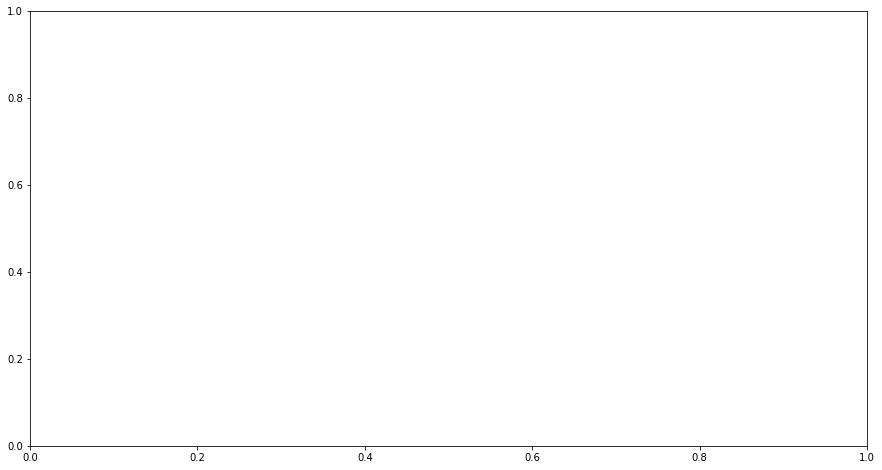

In [41]:
#hide
fig, ax = plt.subplots(figsize=(15, 8))

def draw_barchart(current_day):
    dff = g[g['day'].eq(current_day)].sort_values(by='value', ascending=True).tail(10)
    ax.clear()
    ax.barh(dff['name'], dff['value'], color=[colors[group_lk[x]] for x in dff['name']])
    dx = dff['value'].max() / 200
    
    for i, (value, name) in enumerate(zip(dff['value'], dff['name'])):
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value-dx, i-.25, group_lk[name], size=10, color='#444444', ha='right', va='baseline')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    ax.text(1, 0.4, current_day, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Population (thousands)', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    
    ax.text(0, 1.15, 'Coronavirus',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
#     ax.text(1, 0, 'by @pratapvardhan; credit @jburnmurdoch', transform=ax.transAxes, color='#777777', ha='right',
#             bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)

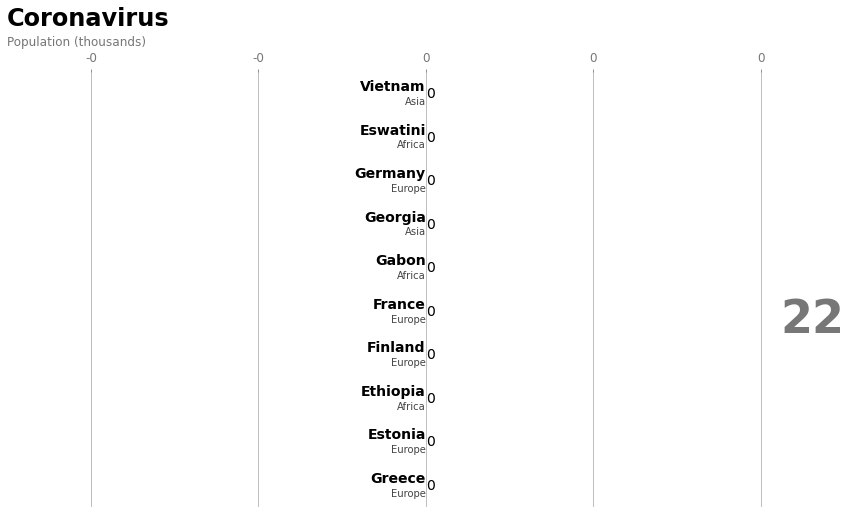

In [42]:
#hide_input
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(g.day.values.min(), g.day.values.max()))
HTML(animator.to_jshtml())
# or use animator.to_html5_video() or animator.save() 